In [1]:
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib import colors, rcParams
from matplotlib.ticker import AutoMinorLocator, MaxNLocator
from matplotlib.colorbar import Colorbar

In [2]:
# RC params
# Do not touch!
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
rcParams["axes.edgecolor"] = 'black'
rcParams["legend.edgecolor"] = '0.8'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

# Simulation units
SIMTIME = 4.7e7     # yr   - time (this is 4.7 * 10^7
MASS = 1e8          # Msun - mass (this is 1 * 10^8
VELOCITY = 20.74    # km/s - velocity
SCALE = 1000        # scaling value

######    ALL ITEMS ABOVE ARE PRE-LOADED IN QUIZZES   ######

In [3]:
### PART 1: DATA handling ###
def init_array():
    new_tuple = ([],[],[],[],[])
    return new_tuple


def convert_to_np(components):
    numpy_array = np.array(components)
    return numpy_array


def scale_arrays(array):
    if len(array)>0:
        array[0]=array[0]*SCALE
        array[1]=array[1]*SCALE
        array[2]=array[2]*SCALE

        array[3]=array[3]*VELOCITY
        array[4]=array[4]*VELOCITY
        array[5]=array[5]*VELOCITY

        array[6]=array[6].astype(int)
        array[8]=array[8]*MASS
    return array


def generate_timestamp(components):
    for i in range(len(components)):
        components[i]= convert_to_np(components[i])
        for j in range(len(components[i])):
            components[i][j] = scale_arrays(components[i][j])
    return components
            

def generate_4d_data(data_file):
    types = init_array()
    f = open(data_file)
    data4d =[]
    time_step =[]
    data_list=[np.fromstring(line,dtype='float',sep=' ') for line in f]
    time_step_validator = False;
    for i in range(len(data_list)):
        if (i>4 and time_step_validator==True) or (i == (len(data_list)-1)):
            data4d.append(generate_timestamp(list(types)))
            time_step_validator=False
            '''for x in range(len(types)):
                for y in range(len(types[x])):
                    print(types[x][y])'''
            types=init_array()
            
        if len(data_list[i])==2:
            time_step.append(data_list[i][1])
            time_step_validator = True
        elif len(data_list[i])==12:
            time_step_validator=False;
            if data_list[i][6]==0:
                types[0].append(data_list[i])
            elif data_list[i][6]==1:
                types[1].append(data_list[i])
            elif data_list[i][6]==2:
                types[2].append(data_list[i])
            elif data_list[i][6]==3:
                types[3].append(data_list[i])
            elif data_list[i][6]==4:
                types[4].append(data_list[i])
            else:
                print("WARNING: unknown ID argument")
                return
    return data4d,time_step
        
    

In [4]:
### PART 2: DATA manipulation (pandas) ###
def convert_to_pd(col_header, data4d):
    col_header.extend(("k","l","m"))
    old  = pd.DataFrame(columns=col_header)
    new  = pd.DataFrame(columns=col_header)
    gas  = pd.DataFrame(columns=col_header)
    gal  = pd.DataFrame(columns=col_header)
    for i in range(3):
        if(len(data4d[i][3])>0):
            temp = pd.DataFrame(data=data4d[i][3],columns=col_header)
            old = pd.concat([old,temp],axis=0)
        if(len(data4d[i][4])>0):
            temp = pd.DataFrame(data=data4d[i][4],columns=col_header)
            new = pd.concat([new,temp],axis=0)
        if(len(data4d[i][2])>0):
            temp = pd.DataFrame(data=data4d[i][2],columns=col_header)
            gas = pd.concat([gas,temp],axis=0)
        if(len(data4d[i][1])>0):
            temp = pd.DataFrame(data=data4d[i][1],columns=col_header)
            gal = pd.concat([gal,temp],axis=0)
    old = old.drop(columns=["k","l","m"])  
    new = new.drop(columns=["k","l","m"])
    gas = gas.drop(columns=["k","l","m"])
    gal = gal.drop(columns=["k","l","m"])
    
    return old,new,gas,gal


def particle_stats(particle, col_name):
    if col_name in particle.columns:
        stats = particle.describe()
        return stats[col_name]['min'],stats[col_name]['mean'],stats[col_name]['max']
    else:
        return None

In [5]:
### PART 3: Visualisation ###
def plot_single_particle_xy(data4d, time_step, particle, color):
    if particle<=4:
        x = data4d[time_step][particle][:,0]
        y = data4d[time_step][particle][:,1]
        plt.scatter(x,y,s=1,alpha=0.3,c=color)
        return plt
    else:
        print('invalid particle id')
        return None

def plot_multiple_particle_xy(data4d, time_step, particles, colors, alphas):
    for i in range(len(particles)):
        if particles[i]<=4:
            x = data4d[time_step][particles[i]][:,0]
            y = data4d[time_step][particles[i]][:,1]
            plt.scatter(x,y,s=1,alpha=alphas[i],c=colors[i])
        else:
            print('invalid particle id')
            return None
    return plt
        
def star_formation_visualisation(data4d):
    ################################################################
    #preset, don't touch! (but you can change the names if you want)
    fig, axe = plt.subplots(2, 3, sharex=True, sharey=True)
    ax_lims = 1000
    fig.set_size_inches(14, 7)
    gas_col = 'dimgrey'
    old_col = 'red'
    new_col = 'cyan'
    ################################################################
    for row in range(2):
        for col in range(3):
            axe[row, col].set_xlim(-ax_lims, ax_lims)
            axe[row, col].set_ylim(-ax_lims, ax_lims)
    
    x0_gas= data4d[0][2][:,0]
    y0_gas = data4d[0][2][:,1]
    z0_gas = data4d[0][2][:,2]
    
    x0_new= data4d[0][4][:,0]
    y0_new = data4d[0][4][:,1]
    z0_new = data4d[0][4][:,2]
    
    axe[0,0].scatter(x0_gas,y0_gas,s=1,alpha=0.3,c=gas_col)
    axe[0,0].scatter(x0_new,y0_new,s=1,alpha=0.1,c=new_col)
    axe[1,0].scatter(x0_gas,z0_gas,s=1,alpha=0.3,c=gas_col)
    axe[1,0].scatter(x0_new,z0_new,s=1,alpha=0.1,c=new_col)
    
    x1_gas= data4d[1][2][:,0]
    y1_gas = data4d[1][2][:,1]
    z1_gas = data4d[1][2][:,2]
    
    x1_new= data4d[1][4][:,0]
    y1_new = data4d[1][4][:,1]
    z1_new = data4d[1][4][:,2]
    
    x1_old= data4d[1][3][:,0]
    y1_old = data4d[1][3][:,1]
    z1_old = data4d[1][3][:,2]
    
    axe[0,1].scatter(x1_gas,y1_gas,s=1,alpha=0.3,c=gas_col)
    axe[0,1].scatter(x1_new,y1_new,s=1,alpha=0.1,c=new_col)
    axe[0,1].scatter(x1_old,y1_old,s=1,alpha=1,c=old_col)
    axe[1,1].scatter(x1_gas,z1_gas,s=1,alpha=0.3,c=gas_col)
    axe[1,1].scatter(x1_new,z1_new,s=1,alpha=0.1,c=new_col)
    axe[1,1].scatter(x1_old,z1_old,s=1,alpha=1,c=old_col)
    
    x2_gas= data4d[2][2][:,0]
    y2_gas = data4d[2][2][:,1]
    z2_gas = data4d[2][2][:,2]
    
    x2_new= data4d[2][4][:,0]
    y2_new = data4d[2][4][:,1]
    z2_new = data4d[2][4][:,2]
    
    x2_old= data4d[2][3][:,0]
    y2_old = data4d[2][3][:,1]
    z2_old = data4d[2][3][:,2]
    
    axe[0,2].scatter(x2_gas,y2_gas,s=1,alpha=0.3,c=gas_col)
    axe[0,2].scatter(x2_new,y2_new,s=1,alpha=0.1,c=new_col)
    axe[0,2].scatter(x2_old,y2_old,s=1,alpha=1,c=old_col)
    axe[1,2].scatter(x2_gas,z2_gas,s=1,alpha=0.3,c=gas_col)
    axe[1,2].scatter(x2_new,z2_new,s=1,alpha=0.1,c=new_col)
    axe[1,2].scatter(x2_old,z2_old,s=1,alpha=1,c=old_col)
    

def fmt(x, pos):
    if x == 0:
        return '0'
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return '${} \times 10^{{{}}}$'.format(a, b)    


def individual_particles(data4d, particles):
    """Plot density of particles"""
    #Already implemented for you
    rang = 500
    my_range = [-500, 500]
    old, new, gas, gal = particles
     
    old_hist, xedges, yedges = np.histogram2d(old.x_scale, 
                                              old.y_scale, 
                                              bins=rang*2, 
                                              range=(my_range, my_range), 
                                              weights=old.mass)
    new_hist, xedges, yedges = np.histogram2d(new.x_scale, 
                                              new.y_scale, 
                                              bins=rang*2, 
                                              range=(my_range, my_range), 
                                              weights=new.mass)
    gas_hist, xedges, yedges = np.histogram2d(gas.x_scale, 
                                              gas.y_scale, 
                                              bins=rang*2, 
                                              range=(my_range, my_range), 
                                              weights=gas.mass)
    gal_hist, xedges, yedges = np.histogram2d(gal.x_scale, 
                                              gal.y_scale, 
                                              bins=rang*2, 
                                              range=(my_range, my_range), 
                                              weights=gal.mass)
    
    
    smoothing_sigma = 15 # Used in gaussian smoothing - larger number more smooth
    
    # not that necessary - just makes the plots look nice
    old_hist = gaussian_filter(old_hist, sigma=smoothing_sigma)
    new_hist = gaussian_filter(new_hist, sigma=smoothing_sigma)
    gas_hist = gaussian_filter(gas_hist, sigma=smoothing_sigma)
    gal_hist = gaussian_filter(gal_hist, sigma=smoothing_sigma)
    
    
    # locations of the text box
    text_x = -420
    text_y = 380
    
    # properties of the textbox
    props = dict(facecolor='white', alpha=0.9)  
    
    # Using gridspec here but this can also be done with subplots as well
    fig = plt.figure()
    grid = gridspec.GridSpec(1, 5, width_ratios=[1, 1, 1, 1, 0.05])  
    cbax = plt.subplot(grid[:, -1])
    ax0 = plt.subplot(grid[0, 0]) # bottom left
    ax1 = plt.subplot(grid[0, 1], sharey=ax0) # bottom right
    ax2 = plt.subplot(grid[0, 2], sharex=ax0) # top left
    ax3 = plt.subplot(grid[0, 3], sharex=ax1, sharey=ax2) # top right
    fig.set_size_inches(16, 3.75)
    
    plt.setp(ax1.get_yticklabels(), visible=False) # more gridspec syntax
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax3.get_yticklabels(), visible=False)
    
    
    gamma = 0.2 # Used in the colorbar normalisation
    cmap = plt.cm.get_cmap('plasma')
    
    # Need to find the maximum mass across all histograms
    gal_max = np.max(gal_hist)
    gas_max = np.max(gas_hist)
    new_max = np.max(new_hist)
    old_max = np.max(old_hist)
    
    # Set this to be the max value of the histograms
    all_max = max([gal_max, gas_max, new_max, old_max])
    
    
    # Start plotting!
    fields = [(ax0, gal_hist, 'Disc Stars'),
              (ax1, gas_hist, 'Gas'),
              (ax2, old_hist, 'Old Stars'),
              (ax3, new_hist, 'New Stars')
              ]
    
    for ax, hist, name in fields:
        im = ax.imshow(hist.T, cmap=cmap, origin='lower', 
                       vmin=0, vmax=all_max, 
                       norm=mcolors.PowerNorm(gamma), 
                       extent=[-rang, rang, -rang, rang])
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.text(text_x, text_y, name, bbox=props)        
        ax.tick_params(direction='in', axis='both', which='both', 
                       bottom=True, top=True, left=True, right=True)

    # Unneccecary astro convention to have all your ticks facing inwards
    grid.update(left=0.05, right=0.95, bottom=0.08, top=0.93, 
              wspace=0.1, hspace=0.05)   
    
    # X Y text locations
    fig.text(0.001, 0.5, 'Y (pc)', va='center', rotation='vertical')
    fig.text(0.5, -0.01, 'X (pc)', va='center')
    
    # Colourbar - use external function to turn it into 
    # scientific notation but not essential
    cb = Colorbar(ax=cbax, mappable=im , format=ticker.FuncFormatter(fmt), 
                  ticks=[1e2, 5e2, 1e3])
    cb.set_label('M$_\odot$pc$^{-2}$', labelpad=10)
    
    plt.show()
    return plt


def compute_center(particles, center):
    for i in range(len(particles)):
        particles[i]['x_scale'] = particles[i]['x']-center[0]
        particles[i]['y_scale'] = particles[i]['y']-center[1]
        particles[i]['z_scale'] = particles[i]['z']-center[2]
    return particles


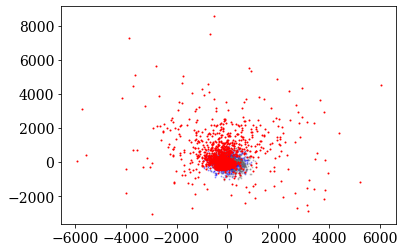

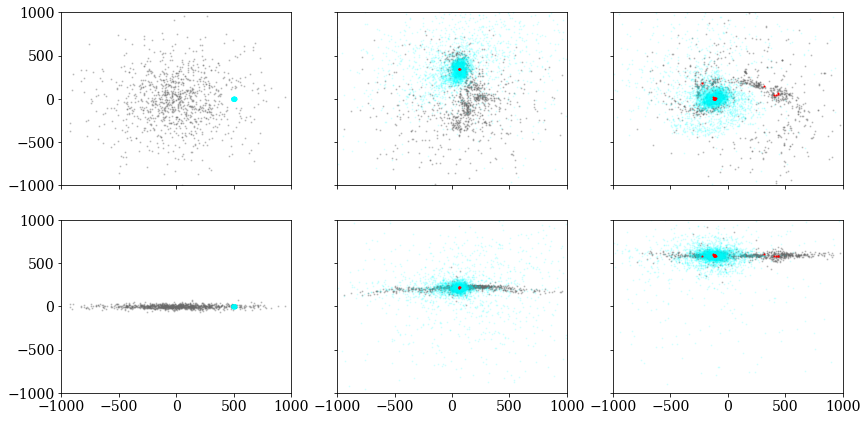

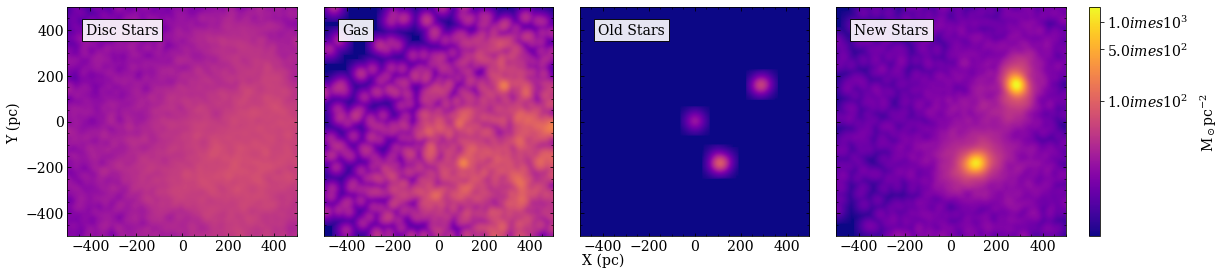

In [6]:
def main(): 
    """ Main function executing the whole code.
        Uncomment functions as you go.
    """
    data_file = "low_res_1.dat"       
    
    ##part 1: after completing task 1 functions, below should work correctly.
    data4d, time_array = generate_4d_data(data_file)
    ##convert it to numpy array
    data4d = np.array(data4d)


    ##part 2: after completing task 2 functions, below should work correctly.
    col_header = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'iwas', 'id', 'mass']
    old, new, gas, gal = convert_to_pd(col_header, data4d)
    
    
    
    
    ##part 3: after completing task 3 functions, below should work correctly.
    plot_single_particle_xy(data4d, 0, 2, 'blue')
    
    gas_col = 'dimgrey'
    old_col = 'cyan' 
    new_col = 'red'
    colors = [gas_col, old_col, new_col]
    alphas = [0.3, 0.1, 1]
    plot_multiple_particle_xy(data4d, 2, [2, 3, 4], colors, alphas)
    
    
    star_formation_visualisation(data4d) 
    
    ##This is for the last question
    ## X Y Z positions of the 1st old star paricle  
    center = data4d[-1][3][0, 0:3] 
    
    particles = (old, new, gas, gal)
    particles = compute_center(particles, center)
    individual_particles(data4d, particles)

if __name__ == "__main__":
    main()